In [1]:
import os, sys
# Append the parent directory to the system path
sys.path.append(os.path.abspath('..'))

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras import layers

from src.preprocessing.data_preprocessing import ResumeTextPreprocessor, NLPPreprocessor, ImbalancedNLPHandler
from src.training.training import call_data, create_and_compile_model
from src.model.model import TextAnalysisModel2, TextClassifier

from src.utils.helpers import plot_accuracy

Cleaning text data...
Found potentially problematic words:
Problem word: ntp
Problem word: ntp
Found potentially problematic words:
Problem word: npc
Found potentially problematic words:
Problem word: nac
Problem word: nac
Tokenizing text...
Splitting data...


c:\Projs\COde\ResAnalysis\resanalysis\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [2]:
data = call_data()
data

,ID,Category,Resume
0,1,HR,"b'John H. Smith, P.H.R.\n800-991-5187 | PO Box..."
1,2,HR,b'Name Surname\nAddress\nMobile No/Email\nPERS...
2,3,HR,b'Anthony Brown\nHR Assistant\nAREAS OF EXPERT...
3,4,HR,b'www.downloadmela.com\nSatheesh\nEMAIL ID:\nC...
4,5,HR,"b""HUMAN RESOURCES DIRECTOR\n\xef\x82\xb7Expert..."
...,...,...,...
1214,1215,Aviation,"b""Free Flight Attendant Resume\nDarlene Flint\..."
1215,1216,Aviation,b'Corporate Flight Attendant Resume\nCAITLIN F...
1216,1217,Aviation,"b'MAJOR CONRAD A. PREEDOM\n2354 Fairchild Dr.,..."
1217,1218,Aviation,b'STACY SAMPLE\n\n702 800-0000 cell\n\n0000@em...


In [11]:
### UTILIZING EXISITING PREPROCESSOR

import tensorflow as tf
import numpy as np
from typing import List, Dict, Union, Tuple
from collections import Counter
from sklearn.utils import resample

class ImbalancedNLPHandler:
    def __init__(self,
                 preprocessor: NLPPreprocessor,
                 strategy: str = "weighted"):
        """
        Combines NLPPreprocessor with imbalanced data handling.
        
        Args:
            preprocessor: Existing NLPPreprocessor instance
            strategy: "weighted", "oversample", or "undersample"
        """
        self.preprocessor = preprocessor
        self.strategy = strategy
    
    def calculate_class_weights(self, labels: List) -> Dict:
        """Calculate class weights for imbalanced data."""
        class_counts = Counter(labels)
        total = len(labels)
        weights = {cls: total / count for cls, count in class_counts.items()}
        
        # Normalize weights
        weight_sum = sum(weights.values())
        weights = {cls: weight / weight_sum for cls, weight in weights.items()}
        
        return weights
    
    def oversample(self, texts: List[str], labels: List) -> Tuple[List[str], List]:
        """Oversample minority classes."""
        df = pd.DataFrame({'text': texts, 'label': labels})
        class_counts = Counter(labels)
        majority_size = max(class_counts.values())
        
        balanced_dfs = []
        for label in class_counts.keys():
            class_df = df[df['label'] == label]
            if len(class_df) < majority_size:
                resampled = resample(class_df,
                                   replace=True,
                                   n_samples=majority_size,
                                   random_state=42)
                balanced_dfs.append(resampled)
            else:
                balanced_dfs.append(class_df)
        
        balanced_df = pd.concat(balanced_dfs)
        return balanced_df['text'].tolist(), balanced_df['label'].tolist()
    
    def undersample(self, texts: List[str], labels: List) -> Tuple[List[str], List]:
        """Undersample majority classes."""
        df = pd.DataFrame({'text': texts, 'label': labels})
        class_counts = Counter(labels)
        minority_size = min(class_counts.values())
        
        balanced_dfs = []
        for label in class_counts.keys():
            class_df = df[df['label'] == label]
            if len(class_df) > minority_size:
                resampled = resample(class_df,
                                   replace=False,
                                   n_samples=minority_size,
                                   random_state=42)
                balanced_dfs.append(resampled)
            else:
                balanced_dfs.append(class_df)
        
        balanced_df = pd.concat(balanced_dfs)
        return balanced_df['text'].tolist(), balanced_df['label'].tolist()

    def prepare_balanced_data(self, texts: List[str], labels: List, use_word2vec: bool = False):
        """Prepare data with imbalance handling."""
        # Apply balancing strategy if needed
        if self.strategy == "oversample":
            texts, labels = self.oversample(texts, labels)
        elif self.strategy == "undersample":
            texts, labels = self.undersample(texts, labels)
        
        # Use existing preprocessor to prepare data
        data = self.preprocessor.prepare_data(texts, labels, use_word2vec)
        
        # Add class weights if using weighted strategy
        if self.strategy == "weighted":
            class_weights = self.calculate_class_weights(data['y_train'])
            data['class_weights'] = class_weights
            
            # Update datasets to use sample weights
            weights = [class_weights[label] for label in data['y_train']]
            data['train_dataset'] = tf.data.Dataset.from_tensor_slices(
                (data['X_train'], data['y_train'], weights)
            ).shuffle(10000).batch(32)
        
        return data
    
    def get_class_distribution(self, labels: List) -> Dict:
        """Calculate class distribution percentages."""
        total = len(labels)
        class_counts = Counter(labels)
        return {label: count/total * 100 for label, count in class_counts.items()}

# Example custom model that can use the preprocessor's word2vec embeddings
class CustomTextClassifier(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, num_classes, embedding_matrix=None):
        super().__init__()
        
        if embedding_matrix is not None:
            self.embedding = tf.keras.layers.Embedding(
                vocab_size, embedding_dim,
                weights=[embedding_matrix],
                trainable=False
            )
        else:
            self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
            
        self.lstm = tf.keras.layers.LSTM(64)
        self.dense1 = tf.keras.layers.Dense(32, activation='relu')
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.dense2 = tf.keras.layers.Dense(num_classes, activation='softmax')
        
    def call(self, inputs, training=False):
        x = self.embedding(inputs)
        x = self.lstm(x)
        x = self.dense1(x)
        if training:
            x = self.dropout(x)
        return self.dense2(x)

In [3]:
data

,ID,Category,Resume
0,1,HR,"b'John H. Smith, P.H.R.\n800-991-5187 | PO Box..."
1,2,HR,b'Name Surname\nAddress\nMobile No/Email\nPERS...
2,3,HR,b'Anthony Brown\nHR Assistant\nAREAS OF EXPERT...
3,4,HR,b'www.downloadmela.com\nSatheesh\nEMAIL ID:\nC...
4,5,HR,"b""HUMAN RESOURCES DIRECTOR\n\xef\x82\xb7Expert..."
...,...,...,...
1214,1215,Aviation,"b""Free Flight Attendant Resume\nDarlene Flint\..."
1215,1216,Aviation,b'Corporate Flight Attendant Resume\nCAITLIN F...
1216,1217,Aviation,"b'MAJOR CONRAD A. PREEDOM\n2354 Fairchild Dr.,..."
1217,1218,Aviation,b'STACY SAMPLE\n\n702 800-0000 cell\n\n0000@em...


In [4]:
data['cleaned_text'] = data['Resume'].apply(ResumeTextPreprocessor().process_and_check)

# # Initialize your existing preprocessor
# preprocessor = NLPPreprocessor(
#     max_words=10000,
#     max_length=500,
#     embedding_dim=100
# )

# Using your preprocessor
preprocessor = NLPPreprocessor(
    max_words=10000,
    max_length=500,
    embedding_dim=100,
    TFDataset=True
)
data_imbal = preprocessor.prepare_data(
    texts=data['cleaned_text'],
    labels=data['Category'],
    use_word2vec=True  # Use Word2Vec embeddings
)
# data2

if data_imbal['embedding_matrix'] is not None:
        vocab_size = data_imbal['embedding_matrix'].shape[0] 

Found potentially problematic words:
Problem word: ntp
Problem word: ntp
Found potentially problematic words:
Problem word: npc
Found potentially problematic words:
Problem word: nac
Problem word: nac
Analyzing text characteristics...
Average length: 607.49
Median length: 317.00
95th percentile length: 2605.00
Max length: 6149
Total unique words: 32427
Words appearing only once: 12713
Tokenizing texts...
Creating Word2Vec embeddings...
Splitting data...
Creating TF datasets...


In [5]:
# Create the imbalanced handler with your preprocessor
handler = ImbalancedNLPHandler(
    preprocessor=preprocessor,
    # strategy="weighted"
    strategy="oversample"  # "weighted" or "oversample" or "undersample"
    # strategy="undersample"
)

# Check initial class distribution
initial_dist = handler.get_class_distribution(data["Category"])
print("Initial class distribution:", initial_dist)

Initial class distribution: {'HR': 3.3634126333059884, 'Designing': 4.1837571780147655, 'Managment': 6.070549630844955, 'Information Technology': 8.531583264971287, 'Education': 8.367514356029531, 'Advocate': 5.004101722723544, 'Business Development': 3.6095159967186223, 'Health & Fitness': 6.316652994257588, 'Agricultural': 1.9688269073010665, 'BPO': 2.0508613617719442, 'Sales': 5.004101722723544, 'Consultant': 2.1328958162428218, 'Digital Media': 4.4298605414273995, 'Automobile': 2.2149302707136997, 'Food & Beverages': 1.8047579983593112, 'Finance': 5.414273995077933, 'Apparel': 1.1484823625922889, 'Engineering': 9.92616899097621, 'Accountant': 5.496308449548811, 'Building & Construction': 2.3789991796554553, 'Architects': 0.9844134536505332, 'Public Relations': 1.0664479081214109, 'Banking': 3.937653814602133, 'Arts': 3.5274815422477444, 'Aviation': 1.0664479081214109}


In [6]:
# Prepare data with imbalance handling
data = handler.prepare_balanced_data(data["cleaned_text"], data["Category"], use_word2vec=True)

Analyzing text characteristics...
Average length: 562.50
Median length: 308.00
95th percentile length: 1953.80
Max length: 5747
Total unique words: 30307
Words appearing only once: 4695
Tokenizing texts...
Creating Word2Vec embeddings...
Splitting data...
Creating TF datasets...


In [7]:
class_weights = handler.calculate_class_weights(data_imbal["y_train"])

weights = [class_weights[label] for label in data_imbal['y_train']]
weights

[0.023721396388699953,
 0.012408115034089204,
 0.012408115034089204,
 0.010340095861741004,
 0.010340095861741004,
 0.020680191723482007,
 0.10081593465197479,
 0.023721396388699953,
 0.01222011329114846,
 0.012408115034089204,
 0.020680191723482007,
 0.028804552757707085,
 0.012408115034089204,
 0.02987138804502957,
 0.018756452958506937,
 0.01222011329114846,
 0.016130549544315965,
 0.010340095861741004,
 0.042448814590305174,
 0.010340095861741004,
 0.10081593465197479,
 0.010340095861741004,
 0.10081593465197479,
 0.01222011329114846,
 0.012408115034089204,
 0.028804552757707085,
 0.01222011329114846,
 0.017160159089697837,
 0.012408115034089204,
 0.02601701539405801,
 0.02601701539405801,
 0.031020287585223013,
 0.023721396388699953,
 0.017160159089697837,
 0.017160159089697837,
 0.02987138804502957,
 0.018756452958506937,
 0.02987138804502957,
 0.012408115034089204,
 0.010340095861741004,
 0.01222011329114846,
 0.020680191723482007,
 0.02601701539405801,
 0.02601701539405801,
 0.

In [19]:
data['vocab_size']

32429

In [8]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dropout, Dense, BatchNormalization
from tensorflow.keras.regularizers import l2, l1

class TextClassifier(tf.keras.Model):
    def __init__(self, vocab_size, embed_dim, num_classes, embedding_matrix=None):
        super(TextClassifier, self).__init__()
        
        # Embedding layer
        self.embedding = Embedding(
            vocab_size, 
            embed_dim, 

            weights=[embedding_matrix] if embedding_matrix is not None else None,
            trainable=embedding_matrix is None
        )
        
        # Multiple parallel convolution layers
        self.conv1 = Conv1D(64, 3, activation='relu', padding='same')
        self.conv2 = Conv1D(32, 4, activation='relu', padding='same')
        self.conv3 = Conv1D(32, 5, activation='relu', padding='same')
        
        # Pooling layers
        self.pool1 = GlobalMaxPooling1D()
        self.pool2 = GlobalMaxPooling1D()
        self.pool3 = GlobalMaxPooling1D()
        
        # Batch normalization and dropout
        self.batch_norm1 = BatchNormalization()
        self.dropout1 = Dropout(0.4)
        
        # Dense layers
        self.dense1 = Dense(128, activation='relu')
        self.batch_norm2 = BatchNormalization()
        self.dropout2 = Dropout(0.4)
        
        self.dense2 = Dense(64, activation='relu')
        self.batch_norm3 = BatchNormalization()
        self.dropout3 = Dropout(0.3)
        
        # Output layer
        self.output_layer = Dense(num_classes, activation='softmax')
        
    def call(self, inputs, training=False):
        # Embedding
        x = self.embedding(inputs)
        
        # Parallel convolutions
        conv1 = self.conv1(x)
        conv2 = self.conv2(x)
        conv3 = self.conv3(x)
        
        # Pooling
        pool1 = self.pool1(conv1)
        pool2 = self.pool2(conv2)
        pool3 = self.pool3(conv3)
        
        # Concatenate
        concat = tf.keras.layers.concatenate([pool1, pool2, pool3])
        
        # First dense block
        x = self.batch_norm1(concat, training=training)
        x = self.dropout1(x, training=training)
        x = self.dense1(x)
        
        # Second dense block
        x = self.batch_norm2(x, training=training)
        x = self.dropout2(x, training=training)
        x = self.dense2(x)
        
        # Third dense block
        x = self.batch_norm3(x, training=training)
        x = self.dropout3(x, training=training)
        
        # Output
        return self.output_layer(x)

In [9]:
### MODEL TRAINING [WITHOUT CLASS BALANCING]

if data['embedding_matrix'] is not None:
    vocab_size = data['embedding_matrix'].shape[0] 

# vocab_size
# # Create and train model
# model_basic = CustomTextClassifier(
#     vocab_size=vocab_size,
#     embedding_dim=preprocessor.embedding_dim,
#     num_classes=data['num_classes'],
#     embedding_matrix=data['embedding_matrix']
# )

model_2 = TextClassifier(
    vocab_size=vocab_size,
    embed_dim=preprocessor.embedding_dim,
    num_classes=data['num_classes'],
    embedding_matrix=data['embedding_matrix']
)

# optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule)

# Compile model
model_2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [10]:
# Train model with class weights if using weighted strategy
if handler.strategy == "weighted":
    print("Using Weighted Class Balancing!")
    history = model_2.fit(
        data['train_dataset'],
        validation_data=data['val_dataset'],
        epochs=50,
        # class_weight=data['class_weights']
    )
else:
    print("Using NO Weighted Class Balancing!")
    history = model_2.fit(
        data['train_dataset'],
        validation_data=data['val_dataset'],
        epochs=50
    )

Using NO Weighted Class Balancing!
Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.0691 - loss: 3.7777 - val_accuracy: 0.0661 - val_loss: 3.8439
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2163 - loss: 2.7638 - val_accuracy: 0.2562 - val_loss: 2.5922
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3447 - loss: 2.2777 - val_accuracy: 0.5165 - val_loss: 1.8473
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4235 - loss: 2.0035 - val_accuracy: 0.6240 - val_loss: 1.4792
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4935 - loss: 1.7489 - val_accuracy: 0.6777 - val_loss: 1.2212
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5690 - loss: 1.5025 - val_accuracy: 0.7273 - val_loss: 1.0580
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6284 - loss: 1.3292 - val_accuracy: 0.7624 - val_loss: 0.9274
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6575 - loss

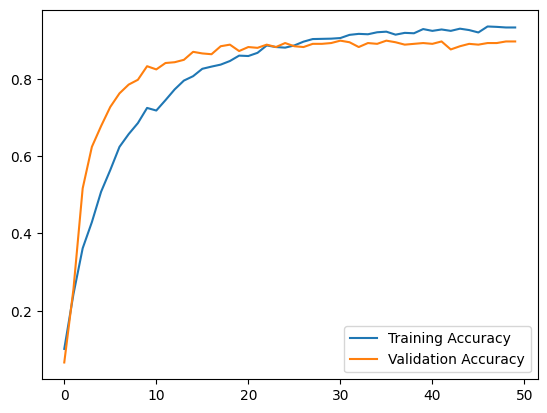

In [11]:
plot_accuracy(history, 'accuracy', 'val_accuracy')

In [59]:
history = model.fit(
    data['train_dataset'],
    validation_data=data['val_dataset'],
    epochs=10
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.1240 - loss: 0.0777 - val_accuracy: 0.0923 - val_loss: 3.0537
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.1028 - loss: 0.0773 - val_accuracy: 0.0718 - val_loss: 3.0991
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.1153 - loss: 0.0764 - val_accuracy: 0.1026 - val_loss: 3.0550
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.1252 - loss: 0.0783 - val_accuracy: 0.0769 - val_loss: 3.0642
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.1073 - loss: 0.0702 - val_accuracy: 0.0769 - val_loss: 3.0796
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.1576 - loss: 0.0727 - val_accuracy: 0.1026 - val_loss: 3.0664
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.1148 - loss: 0.0740 - val_accuracy: 0.0769 - val_loss: 3.0594
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.1452 - loss: 0.0729 - val_accuracy: 0.0974 - v

In [40]:
len(next(iter(data['train_dataset']))[0])

500

In [12]:
np.argmax(model_2.predict(next(iter(data['train_dataset']))[0]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


652

---

# Randoms

In [5]:
import numpy as np

In [7]:
B = np.matrix([[1, 0, 1], [0, 1, 1], [0, 0, 1]])
B

matrix([[1, 0, 1],
        [0, 1, 1],
        [0, 0, 1]])

In [8]:
I = np.eye(3)

In [18]:
B - (1 * I)

matrix([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 0.]])

In [24]:
np.random.randint(0, 9, (3, 3))

array([[2, 5, 0],
       [6, 6, 8],
       [2, 2, 0]])

In [26]:
A = np.array([[2, 5, 0], [0, 6, 0], [1, 2, 8]])
A

array([[2, 5, 0],
       [0, 6, 0],
       [1, 2, 8]])

In [27]:
np.linalg.eigvals(A)

array([8., 2., 6.])

In [28]:
np.sqrt(14)

3.7416573867739413

In [29]:
A = np.array([[1, 1, 0], [0, 1, 2], [0, 0, 3]])

In [30]:
A

array([[1, 1, 0],
       [0, 1, 2],
       [0, 0, 3]])

In [31]:
np.linalg.eig(A)

EigResult(eigenvalues=array([1., 1., 3.]), eigenvectors=array([[ 1.00000000e+00, -1.00000000e+00,  3.33333333e-01],
       [ 0.00000000e+00,  2.22044605e-16,  6.66666667e-01],
       [ 0.00000000e+00,  0.00000000e+00,  6.66666667e-01]]))

In [32]:
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd

def fetch_stock_data(tickers, days_back=30):
    """
    Fetch stock data for given tickers for a specified number of days.
    
    Parameters:
    tickers (list): List of stock ticker symbols (e.g., ['AAPL', 'GOOGL'])
    days_back (int): Number of days of historical data to fetch
    
    Returns:
    dict: Dictionary containing DataFrames with stock data for each ticker
    """
    # Calculate date range
    end_date = datetime.now()
    start_date = end_date - timedelta(days=days_back)
    
    stock_data = {}
    
    for ticker in tickers:
        try:
            # Create ticker object
            stock = yf.Ticker(ticker)
            
            # Fetch historical data
            hist_data = stock.history(start=start_date, end=end_date)
            
            # Get additional stock info
            info = stock.info
            
            # Add important info to the DataFrame
            hist_data['Symbol'] = ticker
            hist_data['Company_Name'] = info.get('longName', '')
            hist_data['Industry'] = info.get('industry', '')
            hist_data['Sector'] = info.get('sector', '')
            hist_data['Market_Cap'] = info.get('marketCap', '')
            
            # Calculate daily returns
            hist_data['Daily_Return'] = hist_data['Close'].pct_change()
            
            # Format the data
            hist_data = hist_data.round(2)
            
            stock_data[ticker] = hist_data
            
        except Exception as e:
            print(f"Error fetching data for {ticker}: {str(e)}")
    
    return stock_data

def get_latest_prices(stock_data):
    """
    Extract the most recent closing prices and details for each stock.
    
    Parameters:
    stock_data (dict): Dictionary of stock DataFrames from fetch_stock_data
    
    Returns:
    pandas.DataFrame: Latest closing prices and details for each stock
    """
    latest_data = []
    
    for ticker, data in stock_data.items():
        if not data.empty:
            latest = data.iloc[-1]
            latest_data.append({
                'Symbol': ticker,
                'Company_Name': latest['Company_Name'],
                'Close': latest['Close'],
                'Volume': latest['Volume'],
                'Daily_Return': latest['Daily_Return'],
                'Industry': latest['Industry'],
                'Sector': latest['Sector'],
                'Market_Cap': latest['Market_Cap']
            })
    
    return pd.DataFrame(latest_data)

ModuleNotFoundError: No module named 'yfinance'